<a href="https://colab.research.google.com/github/turtler12/CV_Homework/blob/main/intro_cv_pset3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 2: Neural Net Inference and Perturbations


Part of this code is based on Alexander Madry's lab robustness applications toolkit and Google Deepdream. You can check more in https://github.com/MadryLab
and https://distill.pub/2017/feature-visualization/


**Note:** To speed up the execution of the experiments we recommend using GPU acceleration. If you run this in Colab, simply do:

Runtime > Change Runtime type > Hardware accelerator > Gpu

In [1]:
# Imports
from matplotlib import pyplot as plt
import torch
from tqdm.notebook import tqdm
import numpy as np
import torchvision.models as models
import cv2
import torchvision.transforms as transforms
import numpy as np
from scipy.signal import convolve2d
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
cuda_available = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(1234)

In [2]:
import requests
def download(url, fn=None):
  if fn is None:
    fn = url.split('/')[-1]
  r = requests.get(url)
  if r.status_code == 200:
      open(fn, 'wb').write(r.content)
      print("{} downloaded: {:.2f} KB".format(fn, len(r.content)/1024.))
  else:
      print("url not found:", url)

In [3]:
download('http://6.869.csail.mit.edu/fa19/psets19/pset6/imagenet_classes.txt')
download('http://6.869.csail.mit.edu/fa19/psets19/pset6/WelshCorgi.jpeg')

imagenet_classes.txt downloaded: 21.17 KB
WelshCorgi.jpeg downloaded: 127.39 KB


# Neural Network Inference

In this exercise, you will be playing with a convolutional neural network to classify images into semantic labels. You will be working with ResNet50, a variant of the residual convolutional network architecture. We will be testing the network to classify an image into one of the 1000 ImageNet categories.

In [4]:
with open('imagenet_classes.txt', 'r') as f:
  imagenet_classes = f.readlines()
  imagenet_classes_short = [x.strip().split(',')[-1] for x in imagenet_classes]

print('Imagenet classes')
for it, class_name in enumerate(imagenet_classes):
  if it == 3:
    print('...')
  elif it < 4 or it > 997:
    print('{}. {}'.format(it, class_name))

Imagenet classes
0. tench, Tinca tinca

1. goldfish, Carassius auratus

2. great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias

...
998. ear, spike, capitulum

999. toilet tissue, toilet paper, bathroom tissue


## Running a randomly initialized network
We will start by using a randomly initalized ResNet50 to perform classification.

### Load a randomly initalized network (Problem 2a)


In [5]:
# Download ResNet50 from Pytorch repository
arch = 'resnet50'
model = models.__dict__[arch]()
# We set it in eval, so that batch normalization layers are not updated
model.eval();
if cuda_available:
  model.cuda()

In [6]:
# Visualize the last layer
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

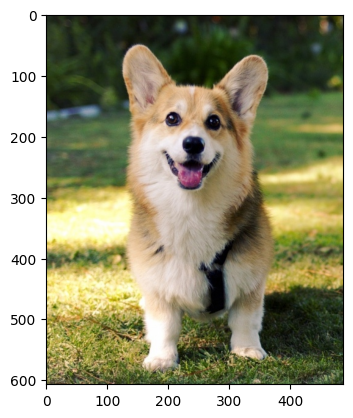

In [7]:
# Load the image we will be playing with
img = cv2.imread('WelshCorgi.jpeg')
plt.imshow(img[:, :, ::-1])


In [8]:
# In order to run the image through a model. We need to prepare it first
# This includes:
# 1. Resizing the image to an appropiate size for the network
# 2. Convert the image to a tensor - this will set the image in the 0-1 range
#    and change the channel/dimensions order
# 3. Normalize the image
# 4. Put the image in a batch. In our case we will use a single element batch.

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

def prepare_image(image_cv2, do_normalize=True):
  # Resize
  img = cv2.resize(image_cv2, (224, 224))
  img = img[:, :, ::-1].copy()
  # Convert to tensor
  tensor_img = transforms.functional.to_tensor(img)

  # Possibly normalize
  if do_normalize:
    tensor_img = normalize(tensor_img)
  # Put image in a batch
  batch_tensor_img = torch.unsqueeze(tensor_img, 0)

  # Put the image in the gpu
  if cuda_available:
    batch_tensor_img = batch_tensor_img.cuda()
  return batch_tensor_img


def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
  std_arr = torch.tensor(std)[:, None, None]
  mean_arr = torch.tensor(mean)[:, None, None]
  def func(img):
    img = img.clone()
    img *= std_arr
    img += mean_arr
    return img
  return func
unnormalize = UnNormalize()

def obtain_image(tensor_img, do_normalize=True):
  tensor_img = tensor_img.cpu()
  if do_normalize:
    tensor_img = unnormalize(tensor_img)
  img = transforms.functional.to_pil_image((tensor_img.data))
  return img



### Classifying the image (Problem 2b)

This architecture outputs a vector of 1000 elements, that correspond to the class logits: each of the class probabilities before doing a softmax.

In [9]:
# Prepare the image
batch_normalized_img = prepare_image(img)
# Run it through the network
output = model(batch_normalized_img)

Let's visualize the top classes

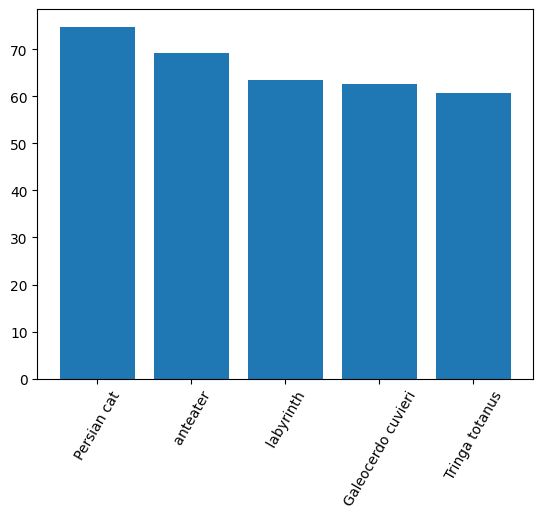

In [10]:
def plot_top_classes(values, top_k=5):
  sorted_classes = np.argsort(-values)
  class_ids = sorted_classes[:top_k]
  class_names = [imagenet_classes_short[it] for it in list(class_ids)]
  class_values = values[class_ids]
  plt.bar(class_names, class_values)
  plt.xticks(rotation=60)


plot_top_classes(output[0,:].data.cpu().numpy())

### Load and run a pre-trained network (Problem 2c)

Unsurprisingly, the network predictions have nothing to do with the image, since the network was intialized from scratch. Instead, we will load the network with the weights after training a classifier on the imagenet dataset.

In [11]:
arch = 'resnet50'
model = models.__dict__[arch](weights=True)
model.eval();
model.cuda();

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


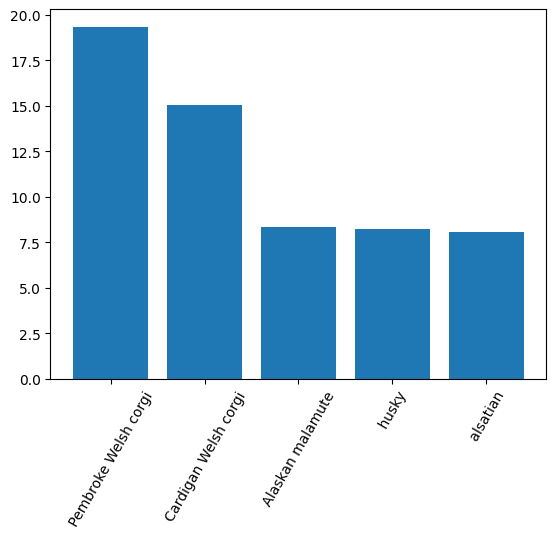

In [12]:
output = model(batch_normalized_img.cuda())
plot_top_classes(output[0,:].data.cpu().numpy())

The top predictions seem to make much more sense now. But it is not clear how to interpret the logits (the raw output scalars). Please normalize the logits into the probability range using the `torch.nn.functional.softmax` function (TODO1).  

In [16]:
def output2prob(output):
  ### START TODO: compute probabilities from logits
  prob = torch.nn.functional.softmax(output, dim=1)

  ### END TODO
  return prob

Now rerun the network, passing the output through our `output2prob` function:

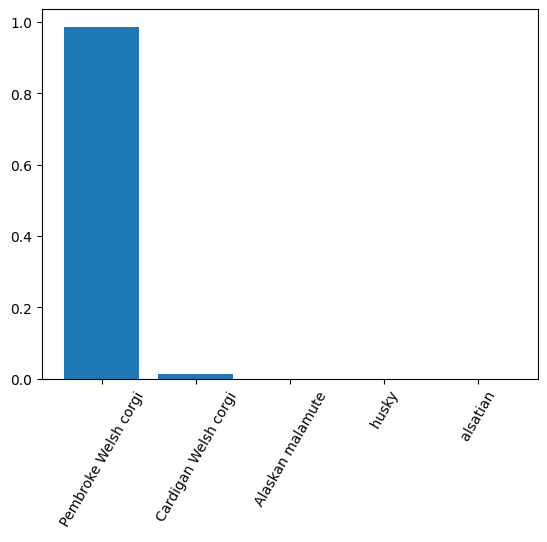

In [17]:
output = model(batch_normalized_img.cuda())
prob = output2prob(output)
plot_top_classes(prob[0,:].data.cpu().numpy())

# Problem 3: CNNs

In this problem, we will train a convolutional neural net to classify images. While this problem is heavily inspired by [Chapter 24.5](https://visionbook.mit.edu/convolutional_neural_nets.html#identifying-vulnerabilities) in the textbook, it is not identical. Therefore, we do not expect the exact same outputs as seen in the book.

In [18]:
# Deterministic Seeding
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [19]:
# Helper functions
def label_to_str(label_int):
    return "Vertical" if label_int == 0 else "Horizontal"

def normalize_image(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

In [20]:
# Dataset generation
def generate_dataset():
    N = 100000
    Nvalidation = 10000
    Nlines = 15
    img_size = 28
    X = np.zeros((N, img_size, img_size), dtype=np.float32)
    for i in range(N):
        tmp = np.zeros((img_size, img_size), dtype=np.float32)
        idx = np.random.permutation(img_size * img_size)[:Nlines]
        vals = (2 + 10 * np.random.rand(Nlines)) * np.sign(np.random.randn(Nlines))
        tmp.flat[idx] = vals
        X[i] = tmp
    for i in range(N // 2):
        region = X[i, 5:23, 5:23]
        region_conv = convolve2d(region, np.ones((9, 1), dtype=np.float32), mode='same')
        X[i, 5:23, 5:23] = region_conv
    for i in range(N // 2, N):
        region = X[i, 5:23, 5:23]
        region_conv = convolve2d(region, np.ones((1, 9), dtype=np.float32), mode='same')
        X[i, 5:23, 5:23] = region_conv
    for i in range(N):
        tmp = np.zeros((img_size, img_size), dtype=np.float32)
        idx = np.random.permutation(img_size * img_size)[:Nlines]
        vals = (2 + 10 * np.random.rand(Nlines)) * np.sign(np.random.randn(Nlines))
        tmp.flat[idx] = vals
        X[i] += tmp

    # Labels: first half = 0 (vertical), second half = 1 (horizontal)
    Y = np.zeros(N, dtype=np.int64)
    Y[N//2:] = 1
    indices = np.random.permutation(N)
    val_idx = indices[:Nvalidation]
    train_idx = indices[Nvalidation:]
    XValidation = X[val_idx]
    YValidation = Y[val_idx]
    XTrain = X[train_idx]
    YTrain = Y[train_idx]

    XTrain = XTrain[:, np.newaxis, :, :]
    XValidation = XValidation[:, np.newaxis, :, :]
    return XTrain, YTrain, XValidation, YValidation, X

def visualize_train_set_samples(images, labels, n_samples=6):
    indices = np.random.choice(len(labels), n_samples, replace=False)
    sample_imgs = images[indices]
    sample_labels = labels[indices]
    fig, axs = plt.subplots(1, n_samples, figsize=(15,3))
    for i, ax in enumerate(axs):
        img_norm = normalize_image(sample_imgs[i,0])
        ax.imshow(img_norm, cmap='gray', interpolation='nearest')
        ax.set_title(label_to_str(sample_labels[i]))
        ax.axis('off')
    plt.suptitle("Training Set Samples")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

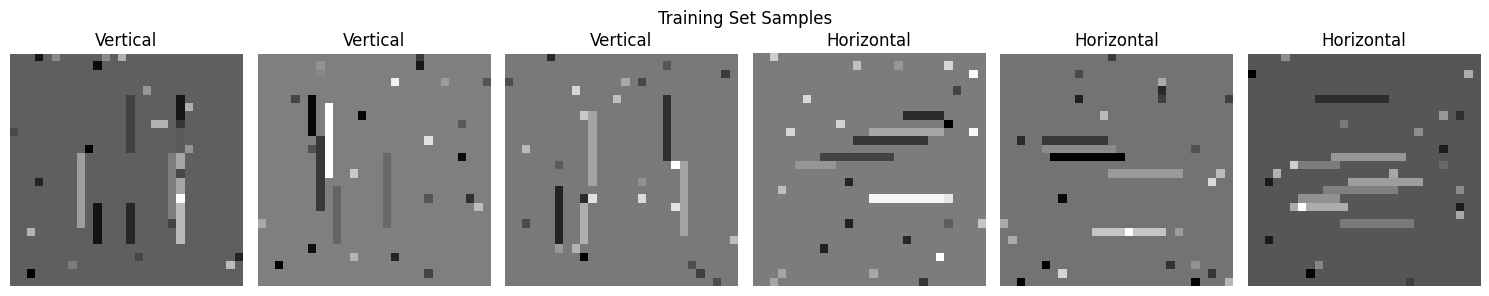

In [21]:
# Visualize sample images
XTrain, YTrain, XTest, YTest, X_full = generate_dataset()
visualize_train_set_samples(XTrain, YTrain, n_samples=6)

In [22]:
# Define dataset for loading data
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img = normalize_image(self.images[idx])
        img_tensor = torch.tensor(img, dtype=torch.float32)
        label = self.labels[idx]
        return img_tensor, label

In [23]:
# Create datasets and dataloaders for train and validation
train_dataset = CustomDataset(XTrain, YTrain)
test_dataset = CustomDataset(XTest, YTest)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Problem 3.1: Initializing a ConvNet

Initialize a simple convolutional neural net model using PyTorch. Use the following layers in order.

1. A convolutional layer with 2 output channels using 9x9 kernels.
2. A ReLU layer
3. A global average pooling layer with an output of size (1,1)
4. A fully connected linear layer

Complete both the initialization and the forward pass.

In [24]:
# Define model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=9)

        # use relu in the forward pass
        self.relu = nn.ReLU()

        # global average pooling layer, output should be of the size (1,1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # fully connected layer
        self.fc = nn.Linear(in_features=2, out_features=2)

        ### END TODO
    def forward(self, x):
        ### START TODO: complete forward pass of model
        # x is of shape (batch_size, 1, H, W), then apply relu
        x = self.conv(x)
        x = self.relu(x)
        # now the shape is (batch_size, 2, 1, 1) and then we flatten to (batch_size, 2)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        ### END TODO
        return x

In [25]:
# Train model
def train_model(model, train_loader, test_loader, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 30
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    accuracy = correct / total
    print(f"Test accuracy: {accuracy*100:.2f}%")
    return model

## Problem 3.2: Training a ConvNet

Train your model using the specified parameters and report your final test accuracy and training losses in your pdf.

In [26]:
# Create and train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model = train_model(model, train_loader, test_loader, device)

Epoch 1/30, Loss: 0.6967
Epoch 2/30, Loss: 0.6159
Epoch 3/30, Loss: 0.4319
Epoch 4/30, Loss: 0.2891
Epoch 5/30, Loss: 0.1990
Epoch 6/30, Loss: 0.1435
Epoch 7/30, Loss: 0.1085
Epoch 8/30, Loss: 0.0854
Epoch 9/30, Loss: 0.0694
Epoch 10/30, Loss: 0.0585
Epoch 11/30, Loss: 0.0504
Epoch 12/30, Loss: 0.0442
Epoch 13/30, Loss: 0.0398
Epoch 14/30, Loss: 0.0363
Epoch 15/30, Loss: 0.0334
Epoch 16/30, Loss: 0.0312
Epoch 17/30, Loss: 0.0292
Epoch 18/30, Loss: 0.0277
Epoch 19/30, Loss: 0.0265
Epoch 20/30, Loss: 0.0254
Epoch 21/30, Loss: 0.0244
Epoch 22/30, Loss: 0.0239
Epoch 23/30, Loss: 0.0230
Epoch 24/30, Loss: 0.0222
Epoch 25/30, Loss: 0.0217
Epoch 26/30, Loss: 0.0213
Epoch 27/30, Loss: 0.0208
Epoch 28/30, Loss: 0.0203
Epoch 29/30, Loss: 0.0202
Epoch 30/30, Loss: 0.0195
Test accuracy: 99.61%


In [27]:
# Evaluation of alternative datasets
def evaluate_set_accuracy(model, images, labels):
    device = next(model.parameters()).device
    if isinstance(images, np.ndarray):
        images_norm = (images - images.min(axis=(1,2,3), keepdims=True)) / (
            images.max(axis=(1,2,3), keepdims=True) - images.min(axis=(1,2,3), keepdims=True) + 1e-8)
        images_tensor = torch.from_numpy(images_norm).float().to(device)
    else:
        images_tensor = images.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(images_tensor)
        _, preds = torch.max(outputs, 1)
    preds = preds.cpu().numpy()
    labels = np.array(labels)
    accuracy = np.mean(preds == labels)
    return accuracy

In [28]:
# Visualize outputs
def visualize_test_set_samples(model, dataset, device):
    vertical_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]
    horizontal_indices = [i for i, (_, label) in enumerate(dataset) if label == 1]
    sample_vert = random.sample(vertical_indices, 6)
    sample_horiz = random.sample(horizontal_indices, 6)
    indices = sample_vert + sample_horiz
    images, true_labels, preds = [], [], []
    model.eval()
    with torch.no_grad():
        for idx in indices:
            img, label = dataset[idx]
            inp = img.unsqueeze(0).to(device)
            output = model(inp)
            _, pred = torch.max(output, 1)
            images.append(img.squeeze().cpu().numpy())
            true_labels.append(label_to_str(label))
            preds.append(label_to_str(int(pred.cpu())))
    fig, axs = plt.subplots(2, 6, figsize=(18, 8))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(normalize_image(images[i]), cmap='gray', interpolation='nearest')
        ax.set_title(f"True: {true_labels[i]}, Pred: {preds[i]}")
        ax.axis('off')
    plt.suptitle("Test Set Samples")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

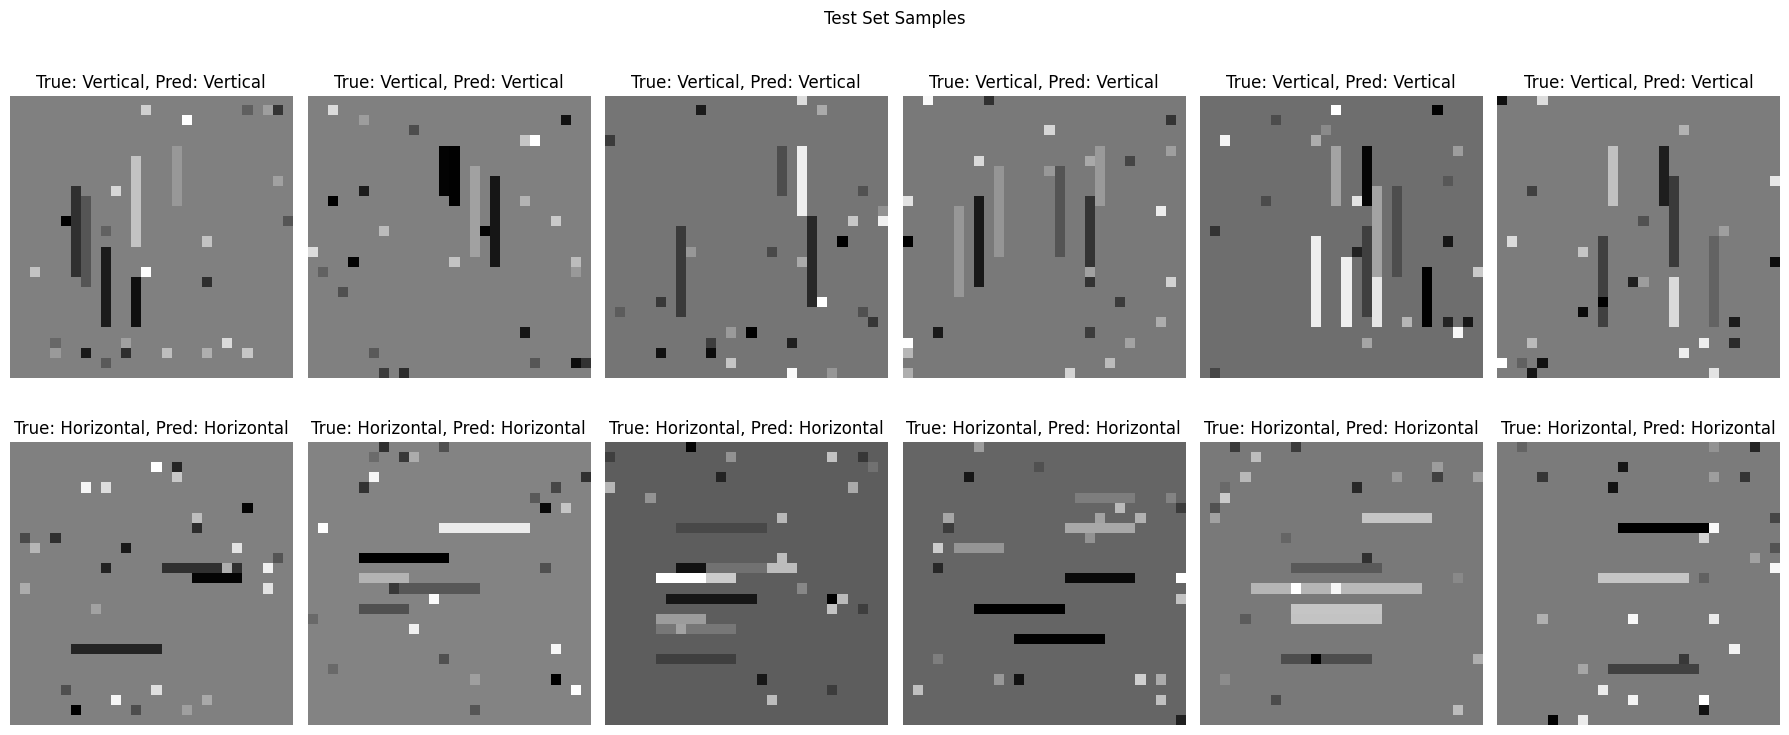

In [29]:
# Visualize examples from test set
visualize_test_set_samples(model, test_dataset, device)

## Problem 3.3: Out of Distribution Examples

Come up with at least two different types of images that are created in a different way compared to the original train and test images but still contain ideas of horizontal or vertical lines. Both types of images should contain horizontal and vertical images. Please briefly describe your examples, visualize, and report out-of-distribution accuracy in your pdf. While we are not requiring any specific performance level on your out of distribution images, we anticipate that our model will perform well on a variety of different cases.

Hint: [Chapter 24.5.4](https://visionbook.mit.edu/convolutional_neural_nets.html#out-of-domain-generalization) in the textbook contains examples of out of distribution images that can be used as inspiration (or used to create similar examples).


In [40]:
def generate_ood_dataset(n_ood):
    """
    Generate an OOD dataset with n_ood samples.
    """
    n_half = n_ood // 2

    def generate_example(mode):
        img = np.zeros((28, 28), dtype=np.float32)

        ### START TODO: Create two different types of out-of-distribution images
        method = random.choice(['method1', 'method2'])

        if method == 'method1':
          # TODO
          # Method description - one line + a bit of sin change
          if mode == 'vertical':
              col = np.random.randint(28)
              img[:, col] = 1.0
           # horizontal case
          else:
              row = np.random.randint(28)
              img[row, :] = 1.0

          # small sinusoidal movement
          freq = 0.1
          xx, yy = np.meshgrid(np.arange(28), np.arange(28))
          sin_pattern = 0.5 + 0.5 * np.cos(2.0 * np.pi * freq * xx)
          img *= sin_pattern
        elif method == 'method2':
          # TODO
          # Method 2: some gaussian noise and a line with a random thickness
          thickness = np.random.randint(1, 3)
          if mode == 'vertical':
              col = np.random.randint(28 - thickness + 1)
              img[:, col:col+thickness] = 1.0
          # horizontal case
          else:
              row = np.random.randint(28 - thickness + 1)
              img[row:row+thickness, :] = 1.0

          # a bit of noise to increase accuracy/traning ability
          noise = np.random.normal(loc=0.0, scale=0.05, size=(28, 28))
          img += noise
          img = np.clip(img, 0.0, 1.0)

        return normalize_image(img)

    vert_examples = [generate_example('vertical') for _ in range(n_half)]
    horiz_examples = [generate_example('horizontal') for _ in range(n_half)]
    ood_examples = np.concatenate([np.stack(vert_examples), np.stack(horiz_examples)], axis=0)
    ood_examples = ood_examples[:, np.newaxis, :, :]
    ood_labels = np.concatenate([
        np.zeros(n_half, dtype=np.int64),
        np.ones(n_half, dtype=np.int64)
    ])
    return ood_examples, ood_labels


def visualize_ood_dataset(model, ood_examples, ood_labels, device):
    ood_acc = evaluate_set_accuracy(model, ood_examples, ood_labels)
    print(f"OOD Dataset Accuracy: {ood_acc * 100:.2f}%")
    idxs = np.random.choice(ood_examples.shape[0], 12, replace=False)
    disp = ood_examples[idxs]
    disp_labels = ood_labels[idxs]
    disp_tensor = torch.from_numpy(disp).float().to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(disp_tensor)
        _, preds = torch.max(outputs, 1)

    preds = [label_to_str(int(p.cpu())) for p in preds]
    true_labels = [label_to_str(l) for l in disp_labels]

    fig, axs = plt.subplots(2, 6, figsize=(18, 8))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(disp[i, 0], cmap='gray', interpolation='nearest')
        ax.set_title(f"True: {true_labels[i]}, Pred: {preds[i]}")
        ax.axis('off')

    plt.suptitle("OOD Dataset Samples")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [41]:
ood_examples, ood_labels = generate_ood_dataset(n_ood=10000)
ood_acc = evaluate_set_accuracy(model, ood_examples, ood_labels)
print(f"Overall OOD Dataset Accuracy: {ood_acc*100:.2f}%")

Overall OOD Dataset Accuracy: 95.83%


OOD Dataset Accuracy: 95.83%


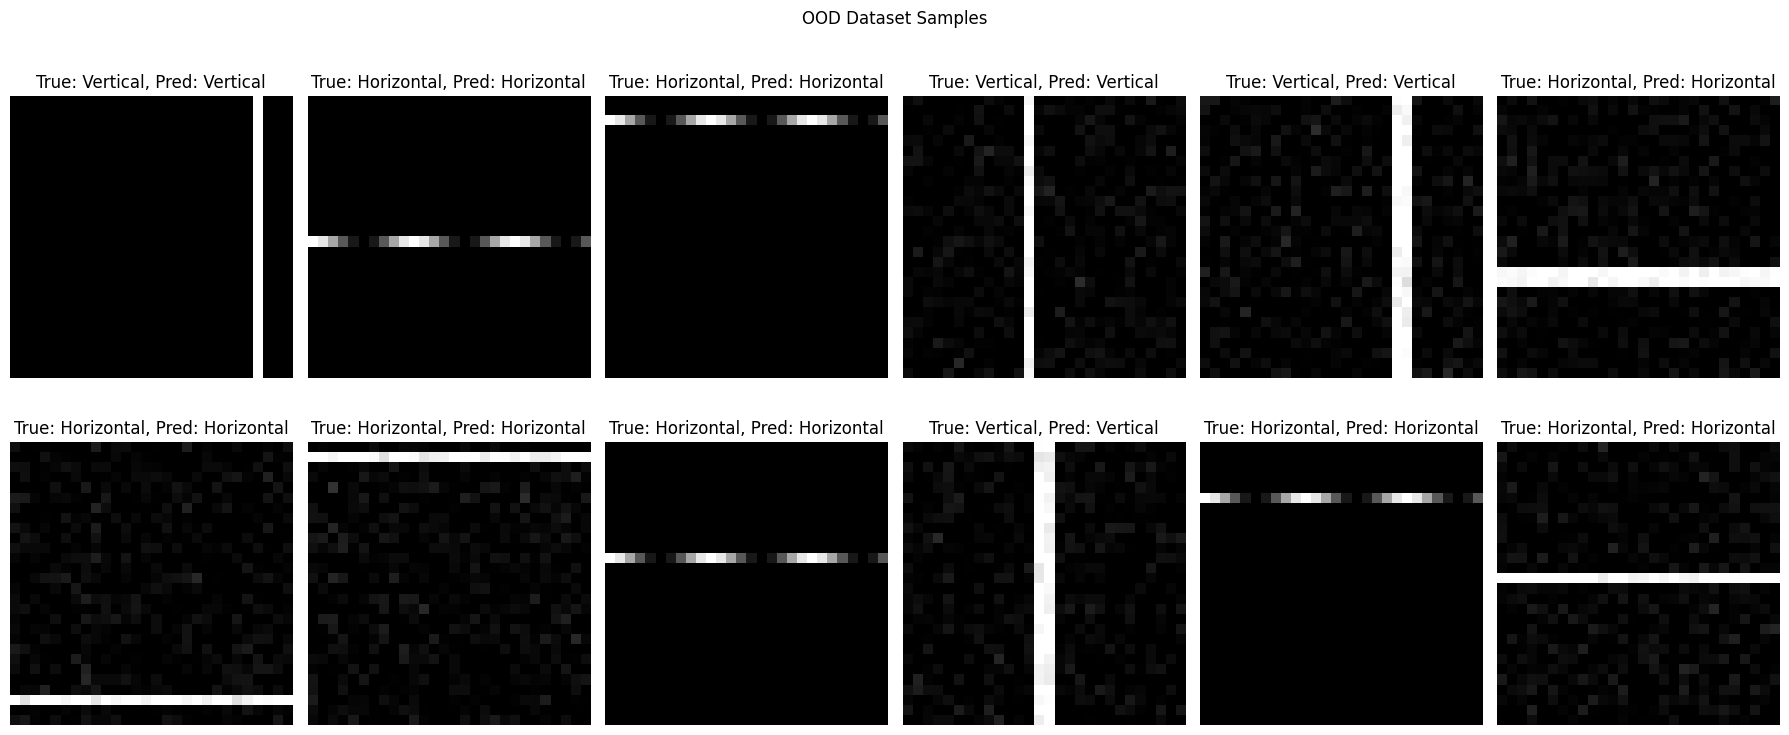

In [42]:
visualize_ood_dataset(model, ood_examples, ood_labels, device)

## Problem 3.4: Adversarial Examples

Generate adversarial examples using modulation, making the lines in our original images have sinusoidal texture. Our goal is to trick the classifier to think its seeing vertical lines, when the actual input is horizontal lines and vice versa. It will be helpful to take a look at [Chapter 24.5.4](https://visionbook.mit.edu/convolutional_neural_nets.html#identifying-vulnerabilities) in the textbook. Please report your classification accuracy and examples of output images.

In [62]:
def generate_adv_dataset(X_val, Y_val, N_adv):
    """
    Generate an adversarial dataset from the first N_adv samples of X_val.
    """
    X_val_np = X_val[:, 0, :, :]
    adv_examples = []
    adv_labels = []
    for i in range(min(N_adv, X_val_np.shape[0])):
        img = X_val_np[i]
        label = Y_val[i]
        ### Save each image as adv_img

        ### START TODO: Complete transform of images to create adverserial example
        # random frequency of socialltions (try many) and create the meshgrid
        freq = 0.01
        xx, yy = np.meshgrid(np.arange(28), np.arange(28))
        if label == 0: # vertical
            pattern = np.cos( 2.0 * np.pi * freq * yy)
        else: # horizontal
            pattern = np.cos( 2.0 * np.pi * freq * xx)
        adv_img = img * pattern
        ### END TODO

        adv_img = normalize_image(adv_img)
        adv_examples.append(adv_img)
        adv_labels.append(label)
    adv_examples = np.stack(adv_examples, axis=0)
    adv_examples = adv_examples[:, np.newaxis, :, :]
    return adv_examples, np.array(adv_labels)

def visualize_adv_dataset(model, adv_examples, adv_labels, device):
    idxs = np.random.choice(adv_examples.shape[0], 12, replace=False)
    disp = adv_examples[idxs]
    disp_labels = adv_labels[idxs]
    disp_tensor = torch.from_numpy(disp).float().to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(disp_tensor)
        _, preds = torch.max(outputs, 1)
    preds = [label_to_str(int(p.cpu())) for p in preds]
    true_labels = [label_to_str(l) for l in disp_labels]
    fig, axs = plt.subplots(2, 6, figsize=(18, 8))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(disp[i, 0], cmap='gray', interpolation='nearest')
        ax.set_title(f"True: {true_labels[i]}, Pred: {preds[i]}")
        ax.axis('off')
    plt.suptitle("Adversarial Dataset Samples")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [63]:
adv_examples, adv_labels = generate_adv_dataset(XTest, YTest, N_adv=10000)
adv_acc = evaluate_set_accuracy(model, adv_examples, adv_labels)
print(f"Adversarial Dataset Accuracy: {adv_acc*100:.2f}%")

Adversarial Dataset Accuracy: 98.08%


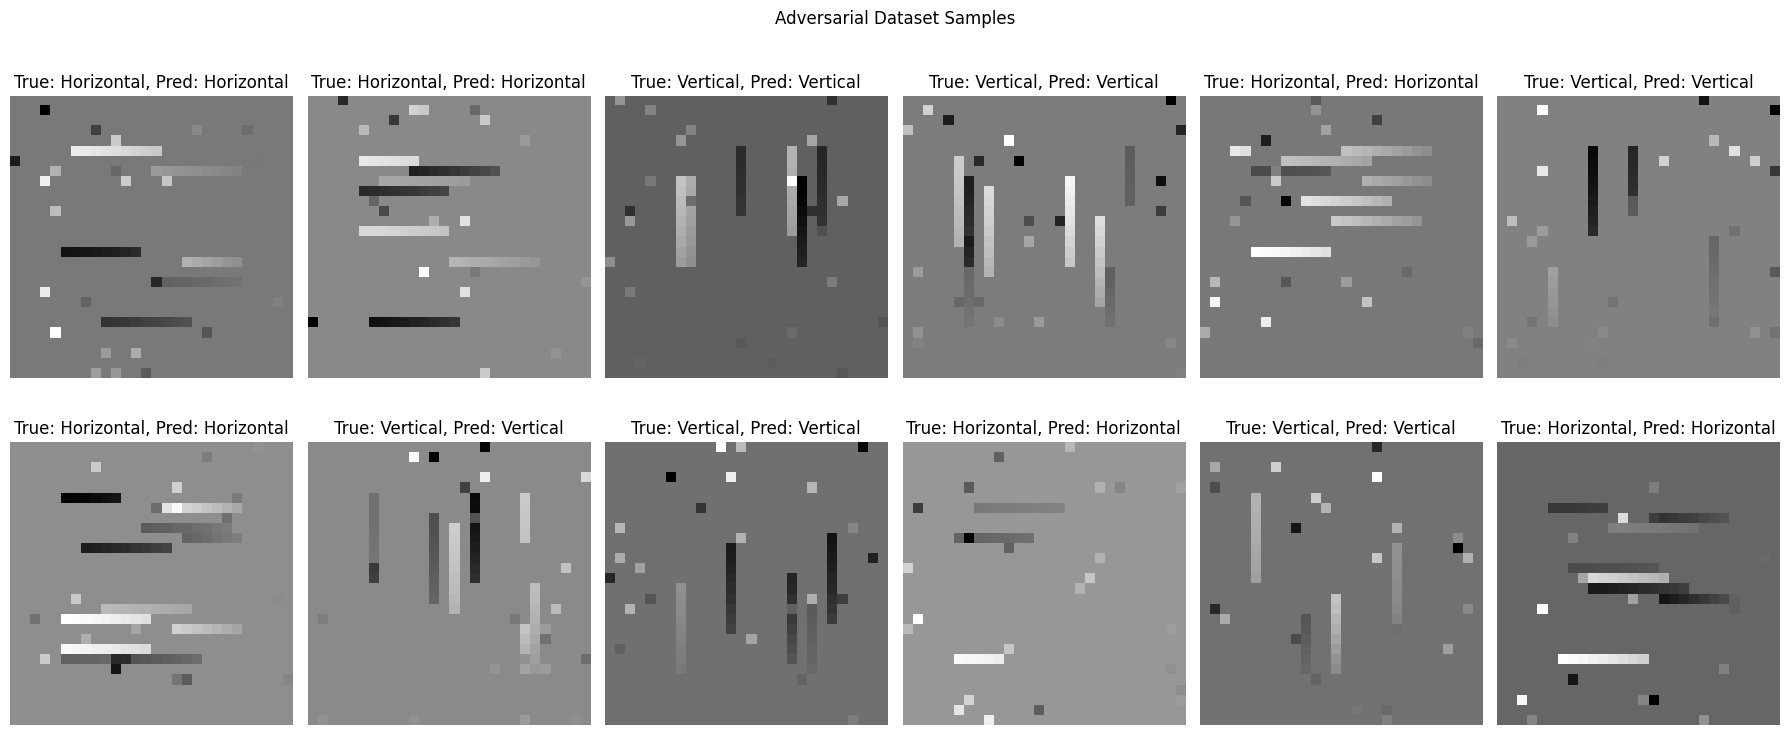

In [64]:
visualize_adv_dataset(model, adv_examples, adv_labels, device)